In [167]:
from dataclasses import dataclass
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapely

json_path = "sdc-test-data.json"

PASS rate: 63.08%, FAIL rate: 36.92%


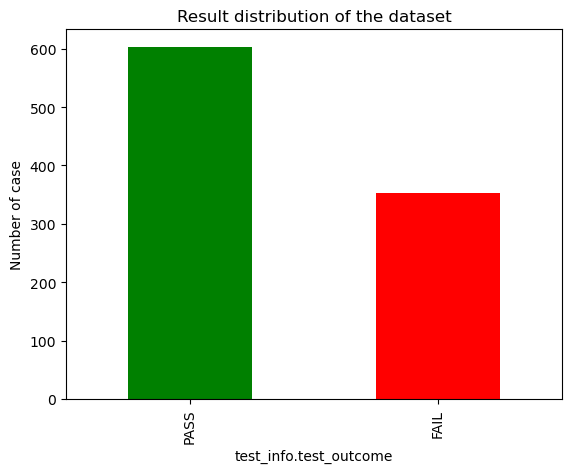

In [163]:
df = pd.read_json("sdc-test-data.json")
meta_df = pd.json_normalize(df["meta_data"])
df_flat = pd.concat([meta_df, df["road_points"]], axis=1)


outcome_counts = df_flat["test_info.test_outcome"].value_counts()
pass_rate = outcome_counts.get("PASS", 0) / len(df_flat) * 100
fail_rate = outcome_counts.get("FAIL", 0) / len(df_flat) * 100
print(f"PASS rate: {pass_rate:.2f}%, FAIL rate: {fail_rate:.2f}%")


plt.figure()
outcome_counts.plot(kind="bar", color=["green", "red"])
plt.title("Result distribution of the dataset")
plt.ylabel("Number of case")
plt.show()

# OBSERVATION OF THE METRIC 
->  RADIUS , DISTANCE , CURVATURE

In [169]:


@dataclass
class TestDetails:
    test_id: str
    hasFailed: bool
    sim_time: float
    road_points: list[tuple[float, float]]


def _curvature_profile(test_detail: TestDetails) -> list[float]:
    """
    Compute the curvature for every meter of the road.

    The following website was used as a reference: https://de.wikipedia.org/wiki/Kr%C3%BCmmung
    """
    #print("compute curvature profile")
    road_shape = shapely.LineString(test_detail.road_points)

    delta_s = 2  # 10 meters

    curvature_profile = np.zeros(int(road_shape.length)) # we want the curvature for every meter
    for s in range(len(curvature_profile)):
        #s = (i+1)*delta_s

        # ignore the edge cases close to the ends of the road
        if (s < delta_s/2) or (s > road_shape.length-delta_s/2):
            continue


        pt_q: shapely.Point = road_shape.interpolate(s-delta_s, normalized=False)
        pt_r: shapely.Point = road_shape.interpolate(s-delta_s/2, normalized=False)

        pt_s: shapely.Point = road_shape.interpolate(s, normalized=False)

        pt_t: shapely.Point = road_shape.interpolate(s+delta_s/2, normalized=False)
        pt_u: shapely.Point = road_shape.interpolate(s+delta_s, normalized=False)

        tangent_r_vec = np.array((pt_s.x-pt_q.x, pt_s.y-pt_q.y))
        tangent_t_vec = np.array((pt_u.x-pt_s.x, pt_u.y-pt_s.y))

        cos_phi = np.dot(tangent_r_vec, tangent_t_vec)/(np.linalg.norm(tangent_r_vec)*np.linalg.norm(tangent_t_vec))
        phi = np.arccos(cos_phi)

        kappa = phi/delta_s
        if np.isnan(kappa):
            continue

        curvature_profile[s] = kappa

    return curvature_profile

In [171]:
def Radius_metric(radius: np.ndarray) -> dict:
    return radius[np.isfinite(radius)]


def _distance_profile(test_detail: TestDetails) -> list[float]:
    """
    Compute the cumulative distance along the road at each meter.

    This function returns the distance from the start of the road for each sampled point.
    """
    road_shape = shapely.LineString(test_detail.road_points)

    delta_s = 1  # Resolution to compute I put 1 meter to be more flexible 
    total_length = int(road_shape.length)

    distance_profile = np.zeros(total_length)

    for s in range(total_length):
        if s < 0 or s > road_shape.length:
            continue

        pt: shapely.Point = road_shape.interpolate(s, normalized=False)
        distance_profile[s] = s 

    return distance_profile



def build_feature_df(tests: List[TestDetails]):
    rows = []
    seuil = 1e-9
    for t in tests:
        kappa = np.asarray(_curvature_profile(t), dtype=float)
        radius = Radius_metric(kappa)
        dist = np.asarray(_distance_profile(t), dtype=float)
        rows.append({
            "test_id": t.test_id,
            "hasFailed": int(bool(t.hasFailed)),
            "sim_time": float(t.sim_time) if t.sim_time == t.sim_time else np.nan,
            ("curvature_mean", "curvature_std"): (np.mean(kappa), np.std(kappa)) , 
            ("dist_mean", "dist_std"): (np.mean(dist), np.mean(dist)) , 
            ("Radius_mean", "Radius_std"): (np.std(radius), np.std(radius))
        })
    return pd.DataFrame(rows)




In [173]:

df = pd.read_json(json_path)


if "meta_data" in df.columns:
    meta_df = pd.json_normalize(df["meta_data"])
    df_flat = pd.concat([meta_df, df["road_points"]], axis=1)
else:
    df_flat = df.copy()

# Colonnes
label_col = "test_info.test_outcome"        
id_col    = "test_info.test_id"            
sim_col   = "test_info.test_duration"                     

tests: List[TestDetails] = []
for i, row in df_flat.iterrows():
    pts_raw = row["road_points"]
    pts = [(p["x"], p["y"]) for p in pts_raw] if isinstance(pts_raw, list) else []


    # BLABLA BLA  this for becoming a dataclass
    test_id = str(row[id_col]) if id_col in df_flat.columns and pd.notna(row[id_col]) else f"test_{i}"
    outcome = str(row[label_col]) if label_col in df_flat.columns and pd.notna(row[label_col]) else "PASS"
    hasFailed = (outcome.upper() == "FAIL")
    sim_time = float(row[sim_col]) if sim_col in df_flat.columns and pd.notna(row[sim_col]) else np.nan

    tests.append(TestDetails(test_id=test_id, hasFailed=hasFailed, sim_time=sim_time, road_points=pts))

df_features = build_feature_df(tests)



In [174]:
curvature_mean = df_features[("curvature_mean", "curvature_std")].apply(lambda x: x[0])
curvature_std = df_features[("curvature_mean", "curvature_std")].apply(lambda x: x[1])


radius_mean = df_features[("Radius_mean", "Radius_std")].apply(lambda x: x[0])
radius_std = df_features[("Radius_mean", "Radius_std")].apply(lambda x: x[1])


dist_mean = df_features[ ("dist_mean", "dist_std")].apply(lambda x: x[0])
dist_std = df_features[ ("dist_mean", "dist_std")].apply(lambda x: x[1])


has_failed = df_features["hasFailed"]



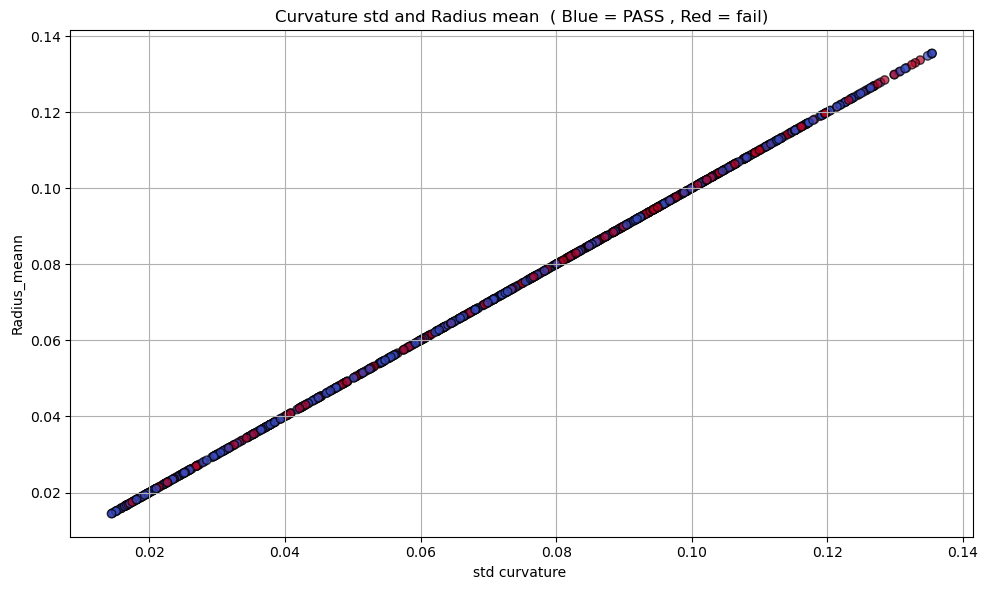

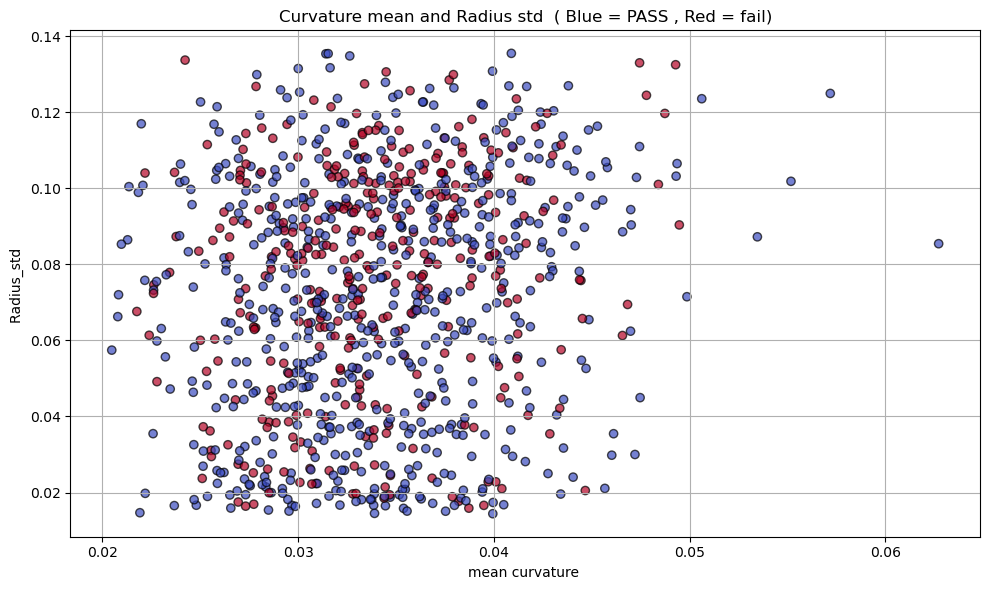

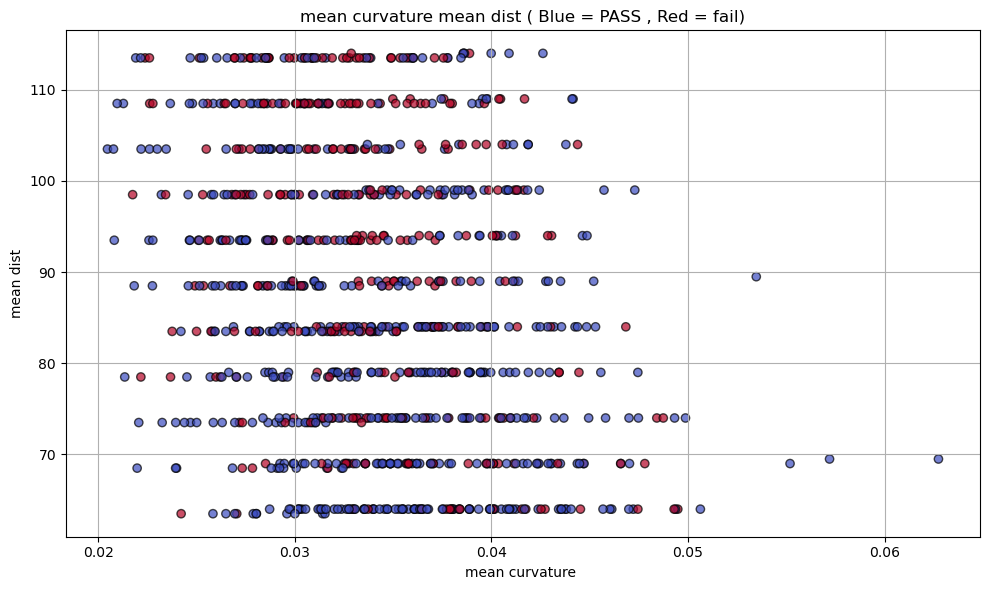

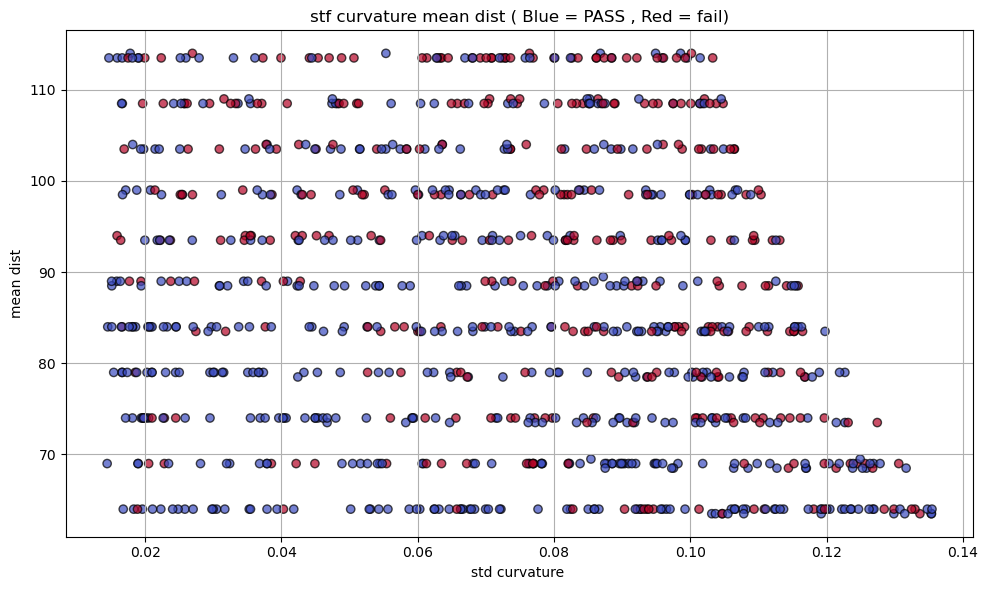

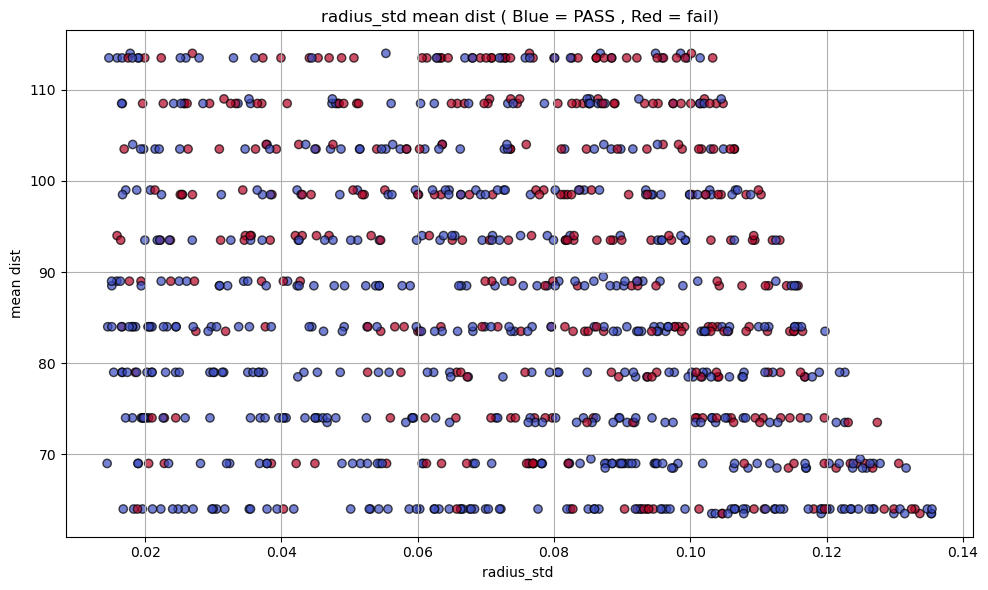

In [175]:

plt.figure(figsize=(10, 6))
scatter = plt.scatter(curvature_std, radius_mean, c=has_failed, cmap="coolwarm", alpha=0.7, edgecolors='k')
plt.xlabel("std curvature ")
plt.ylabel("Radius_meann")
plt.title("Curvature std and Radius mean  ( Blue = PASS , Red = fail)")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
scatter = plt.scatter(curvature_mean, radius_std, c=has_failed, cmap="coolwarm", alpha=0.7, edgecolors='k')
plt.xlabel("mean curvature ")
plt.ylabel("Radius_std ")
plt.title("Curvature mean and Radius std  ( Blue = PASS , Red = fail)")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
scatter = plt.scatter(curvature_mean, dist_mean, c=has_failed, cmap="coolwarm", alpha=0.7, edgecolors='k')
plt.xlabel("mean curvature ")
plt.ylabel("mean dist")
plt.title("mean curvature mean dist ( Blue = PASS , Red = fail)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(curvature_std, dist_mean, c=has_failed, cmap="coolwarm", alpha=0.7, edgecolors='k')
plt.xlabel("std curvature ")
plt.ylabel("mean dist")
plt.title("stf curvature mean dist ( Blue = PASS , Red = fail)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(radius_std, dist_mean, c=has_failed, cmap="coolwarm", alpha=0.7, edgecolors='k')
plt.xlabel("radius_std ")
plt.ylabel("mean dist")
plt.title("radius_std mean dist ( Blue = PASS , Red = fail)")
plt.grid(True)
plt.tight_layout()
plt.show()



## OTHER 

CODE HERE MADE WITH HELP of chat CHAT GPT (because i couldn't achieve satisfactory result with turning the graph

In [185]:
import plotly.graph_objects as go
import numpy as np


# Couleurs : bleu pour PASS, rouge pour FAIL
colors = ['blue' if f == 0 else 'red' for f in has_failed]
labels = ['PASS' if f == 0 else 'FAIL' for f in has_failed]

# Création du scatter 3D
fig = go.Figure(data=[go.Scatter3d(
    x=radius_std,
    y=dist_mean,
    z=curvature_mean,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,
        opacity=0.8,
        line=dict(width=1, color='black')
    ),
    text=labels,
    hoverinfo='text'
)])

# Mise en page
fig.update_layout(
    title="3D Interactive Plot: radius_std vs mean dist vs curvature",
    scene=dict(
        xaxis_title='radius',
        yaxis_title=' dist',
        zaxis_title=' curvature'
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=False
)

# Animation de rotation automatique
frames = []
for angle in range(0, 360, 5):
    frames.append(go.Frame(layout=dict(
        scene_camera=dict(
            eye=dict(x=2*np.cos(np.radians(angle)), y=2*np.sin(np.radians(angle)), z=0.5)
        )
    )))

fig.frames = frames

fig.update_layout(
    updatemenus=[dict(
        type="buttons",
        showactive=False,
        buttons=[dict(label="Play Rotation",
                      method="animate",
                      args=[None, dict(frame=dict(duration=100, redraw=True),
                                       fromcurrent=True, mode='immediate')])]
    )]
)

fig.show()